In [26]:
from utils import read_image, show_image_list
import pymongo
from dotenv import load_dotenv
import os
import torch.nn.functional as F
import torch
from model_pool import ModelEmbedding
from load_config import load_config
import cv2
import torch
from matplotlib import pyplot as plt

In [2]:
load_dotenv()

True

In [3]:
def main(cfg, img_path):
    client = pymongo.MongoClient(os.getenv("MONGOLAB_URI"))
    db = client.simsearch
    collection = db['feature512']
    img = read_image(img_path, target_size=cfg.DATA.IMG_SIZE)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = ModelEmbedding(config = cfg)
    ckpt = torch.load(
        os.path.join(cfg.SAVE_DIR, "checkpoint.pth"),
        map_location="cpu"
    )
    model.load_state_dict(ckpt['model'])
    model.eval()
    model.to(device)
    img.to(device)
    with torch.no_grad():
        vector_query = F.normalize(model(img),1)[0].detach(
            ).cpu().numpy().tolist()
        pipeline = [
            {
                "$search": {
                    "index": "feature512",
                    "knnBeta": {
                        "vector": vector_query,
                        "path": "embedding",
                        "k": 10
                    }
                }
            },
            {
                "$project": {
                    "embedding": 0,
                    "_id": 0,
                    'score': {
                        '$meta': 'searchScore'
                    }
                }
            },
        ]
        res = collection.aggregate(pipeline)
        list_sim = []
        for r in res:
            list_sim.append((r['image_name'], r['score']))
    return list_sim

In [32]:
img_path = r"D:\data\test_simsearch\quannam_test.jpg"
cfg = load_config("../../configs/local.yaml")

In [33]:
list_sim = main(cfg=cfg, img_path=img_path)

Build simple MLP head


In [34]:
list_imgs = [cv2.imread(os.path.join(cfg.ROOT, item[0])) for item in list_sim]
list_scores = [f"score: {item[1]:.3f}" for item in list_sim]
list_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in list_imgs]
query_img = cv2.imread(img_path)
query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)

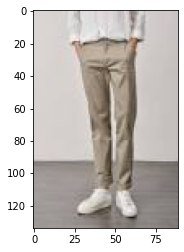

In [35]:
plt.imshow(query_img)

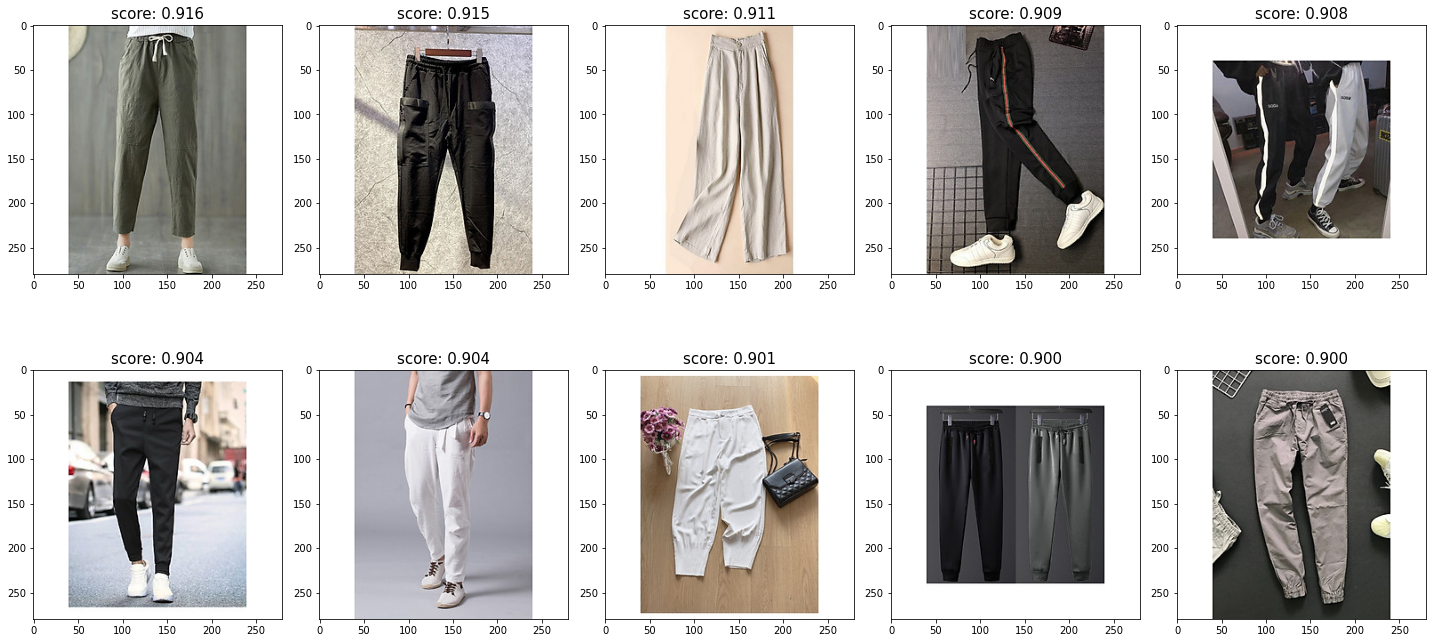

In [36]:
show_image_list(list_images=list_imgs, list_titles=list_scores, grid=False, num_cols=5, title_fontsize=15)